# Coke NFT - Sentiment Analysis
---

In [27]:
# Initial imports
import os
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import nltk as nltk
from newsapi.newsapi_client import NewsApiClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt
import dataframe_image as dfi

%matplotlib inline

In [28]:
# Load .env enviroment variables
load_dotenv()

# Set News API Key
newsapi = NewsApiClient(api_key=os.environ["NEWS_API_KEY"])

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create Alpaca Trade API client
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [29]:
# Create a newsapi client
api_key = os.getenv("NEWS_API_KEY")
newsapi = NewsApiClient(api_key=api_key)

In [52]:
# Fetch news articles
coke_news_en = newsapi.get_everything(
    q="coke nft",
    language="en"
)

# Show the total number of news
coke_news_en["totalResults"]

6

In [53]:
# Function to create a dataframe for news articles
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError as ae:
            pass

    return pd.DataFrame(articles)

In [54]:
# Create news dataframe
coke_df = create_df(coke_news_en["articles"], "en") 
coke_df.head()

,title,description,text,date,language
0,The Marketing DNA Of Successful NFTs: What Bus...,The NFT space didn’t invent the concept of fre...,Cofounder of Yunicorn Ventures. Passionate abo...,2022-06-03,en
1,Today's funny posts,Horror films start like this https://t.co/SvsE...,Horror films start like this https://t.co/SvsE...,2022-05-30,en
2,AMC Entertainment Holdings (AMC) Q1 2022 Earni...,AMC earnings call for the period ending March ...,Image source: The Motley Fool.\r\nAMC Entertai...,2022-05-10,en
3,How Brands Are Incorporating NFTs Into Their C...,Sponsor content from Bybit.,"Sponsor content from Bybit.\r\n""&gt;\r\nSponso...",2022-06-03,en
4,"AMC Entertainment Holdings, Inc. (AMC) CEO Ada...","AMC Entertainment Holdings, Inc. (NYSE:NYSE:AM...","AMC Entertainment Holdings, Inc. (NYSE:AMC) Q1...",2022-05-10,en


In [55]:
# Create the sentiment scores DataFrame
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [56]:
# Create function for sentiment score dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in coke_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

In [57]:
# Attaching sentiment columns to the news dataframe
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
coke_df = coke_df.join(title_sentiment_df).join(text_sentiment_df)

In [58]:
# Describe sentiment 
coke_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,6.000000,6.000000,6.000000,6.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000
mean,0.399333,0.270167,0.729833,0.0,0.833333,0.250217,0.102500,0.847167,0.050333,0.50000
std,0.206478,0.198302,0.198302,0.0,0.408248,0.352337,0.050374,0.089453,0.055182,0.83666
min,0.000000,0.000000,0.408000,0.0,0.000000,-0.296000,0.062000,0.696000,0.000000,-1.00000
25%,0.421500,0.185500,0.663750,0.0,1.000000,0.043150,0.072250,0.810250,0.000000,0.25000
50%,0.430950,0.250000,0.750000,0.0,1.000000,0.335750,0.095000,0.871000,0.048500,1.00000
75%,0.505125,0.336250,0.814500,0.0,1.000000,0.500400,0.097500,0.905500,0.100000,1.00000
max,0.585900,0.592000,1.000000,0.0,1.000000,0.624900,0.200000,0.938000,0.104000,1.00000


In [59]:
# Save output as JPEG for use in readme file
dfi.export(coke_df, 'coke_01.jpg')

[0608/163433.361026:WARNING:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0608/163433.369143:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0608/163433.507084:INFO:headless_shell.cc(660)] Written to file /tmp/tmp_sue1733/temp.png.
[0608/163433.650124:WARNING:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0608/163433.666260:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0608/163433.847316:INFO:headless_shell.cc(660)] Written to file /tmp/tmphtjq5z8v/temp.png.


<AxesSubplot:title={'center':'Coke NFT: News Title and Text Sentiment Comparisson'}>

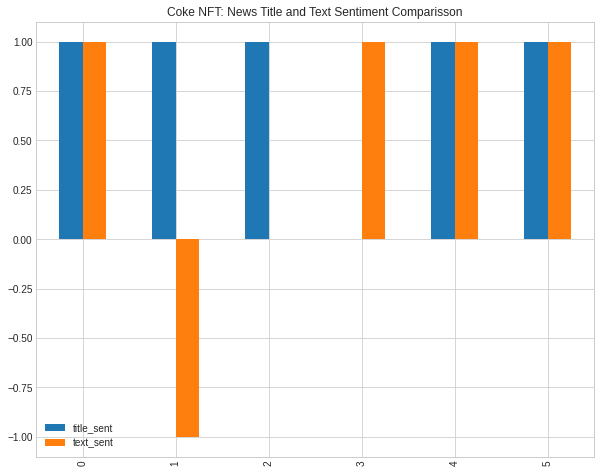

In [60]:
coke_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="Coke NFT: News Title and Text Sentiment Comparisson",
    figsize=(10, 8),
    grid=True,
)

In [61]:
# Save output as JPEG for use in readme file
dfi.export(coke_df, 'coke_02.jpg')

[0608/163454.176741:WARNING:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0608/163454.193544:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0608/163454.330829:INFO:headless_shell.cc(660)] Written to file /tmp/tmpbk8thcnj/temp.png.
[0608/163454.474352:WARNING:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0608/163454.490071:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0608/163454.640063:INFO:headless_shell.cc(660)] Written to file /tmp/tmpjbv7d_vh/temp.png.


---

Natural Language Processing
---
###   Tokenizer

In [62]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import reuters, stopwords
from string import punctuation
import re

In [63]:
# Instantiate the lemmatizer 
lemmatizer = WordNetLemmatizer()
article = coke_df
print(article)

                                               title  \
0  The Marketing DNA Of Successful NFTs: What Bus...   
1                                Today's funny posts   
2  AMC Entertainment Holdings (AMC) Q1 2022 Earni...   
3  How Brands Are Incorporating NFTs Into Their C...   
4  AMC Entertainment Holdings, Inc. (AMC) CEO Ada...   
5       5 brands winning in the metaverse - The Drum   

                                         description  \
0  The NFT space didn’t invent the concept of fre...   
1  Horror films start like this https://t.co/SvsE...   
2  AMC earnings call for the period ending March ...   
3                        Sponsor content from Bybit.   
4  AMC Entertainment Holdings, Inc. (NYSE:NYSE:AM...   
5  The metaverse is a playground of innovation, e...   

                                                text        date language  \
0  Cofounder of Yunicorn Ventures. Passionate abo...  2022-06-03       en   
1  Horror films start like this https://t.co/SvsE...  2022-0

In [64]:
# Create a list of stopwords
sw = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
sw_addons = { "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", 
              "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", 
              "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", 
              "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", 
              "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", 
              "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", 
              "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", 
              "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", 
              "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", 
              "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", 
              "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", 
              "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", 
              "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", 
              "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", 
              "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", 
              "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", 
              "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", 
              "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", 
              "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", 
              "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", 
              "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", 
              "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", 
              "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", 
              "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", 
              "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", 
              "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", 
              "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", 
              "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", 
              "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", 
              "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", 
              "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", 
              "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", 
              "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", 
              "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", 
              "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", 
              "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", 
              "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", 
              "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", 
              "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", 
              "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", 
              "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", 
              "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", 
              "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", 
              "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", 
              "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", 
              "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"}
stop = set(list(sw)+list(sw_addons))

In [65]:
# Define function
def tokenizer(text):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', article)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw]
    return tokens

In [66]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    ## Define and apply the regex parameters
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    
    # Create a tokenized list of the words
    words = word_tokenize(text)
    
    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))
    
    # Remove the punctuation from text
    words = list(filter(lambda t: t not in punctuation, words))
    
    # Remove the stop words
    words = list(filter(lambda t: t.lower() not in stop, words))
    
    # Lemmatize words into root words
    tokens = [lemmatizer.lemmatize(word) for word in words]

    return tokens

In [67]:
# Create a new tokens column in the dataframe
coke_df["tokens"] = coke_df.text.apply(tokenizer)
coke_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,The Marketing DNA Of Successful NFTs: What Bus...,The NFT space didn’t invent the concept of fre...,Cofounder of Yunicorn Ventures. Passionate abo...,2022-06-03,en,0.5859,0.241,0.759,0.0,1,0.5267,0.096,0.904,0.000,1,"[Cofounder, Yunicorn, Ventures, Passionate, th..."
1,Today's funny posts,Horror films start like this https://t.co/SvsE...,Horror films start like this https://t.co/SvsE...,2022-05-30,en,0.4404,0.592,0.408,0.0,1,-0.2960,0.065,0.838,0.097,-1,"[Horror, film, start, http, //t.co/SvsEkv1UAn,..."
2,AMC Entertainment Holdings (AMC) Q1 2022 Earni...,AMC earnings call for the period ending March ...,Image source: The Motley Fool.\r\nAMC Entertai...,2022-05-10,en,0.4215,0.259,0.741,0.0,1,-0.0258,0.098,0.801,0.101,0,"[Image, source, Motley, Fool, AMC, Entertainme..."
3,How Brands Are Incorporating NFTs Into Their C...,Sponsor content from Bybit.,"Sponsor content from Bybit.\r\n""&gt;\r\nSponso...",2022-06-03,en,0.0000,0.000,1.000,0.0,0,0.2500,0.062,0.938,0.000,1,"[Sponsor, content, Bybit, ``, gt, Sponsor, con..."
4,"AMC Entertainment Holdings, Inc. (AMC) CEO Ada...","AMC Entertainment Holdings, Inc. (NYSE:NYSE:AM...","AMC Entertainment Holdings, Inc. (NYSE:AMC) Q1...",2022-05-10,en,0.4215,0.167,0.833,0.0,1,0.4215,0.094,0.906,0.000,1,"[AMC, Entertainment, Holdings, Inc., NYSE, AMC..."


In [68]:
# Save output as JPEG for use in readme file
dfi.export(coke_df, 'coke_03.jpg')

[0608/163538.273436:WARNING:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0608/163538.289465:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0608/163538.395065:INFO:headless_shell.cc(660)] Written to file /tmp/tmplhhvotb8/temp.png.
[0608/163538.541078:WARNING:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0608/163538.556623:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0608/163538.719358:INFO:headless_shell.cc(660)] Written to file /tmp/tmpk6_h_cts/temp.png.
[0608/163538.854396:WARNING:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0608/163538.870700:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0608/163539.063599:INFO:headless_shell.cc(660)] Written to file /tmp/tmpy5ev74xx/temp.png.


---

### NGrams and Frequency Analysis

In [44]:
from collections import Counter
from nltk import ngrams

In [45]:
# Generate N-grams where N=2
N = 2
grams = ngrams(tokenizer(coke_df.text.str.cat()), N)
Counter(grams).most_common(20)

[(('AMC', 'Entertainment'), 2),
 (('Entertainment', 'Holdings'), 2),
 (('Q1', '2022'), 2),
 (('2022', 'Earnings'), 2),
 (('2022', '5:00'), 2),
 (('/li', 'li'), 2),
 (('Sponsor', 'content'), 2),
 (('content', 'Bybit'), 2),
 (('Bybit', '``'), 2),
 (('``', 'gt'), 2),
 (('Cofounder', 'Yunicorn'), 1),
 (('Yunicorn', 'Ventures'), 1),
 (('Ventures', 'Passionate'), 1),
 (('Passionate', 'thing'), 1),
 (('thing', 'branding'), 1),
 (('branding', 'marketing'), 1),
 (('marketing', 'getty'), 1),
 (('getty', 'Spend'), 1),
 (('Spend', 'time'), 1),
 (('time', 'internet'), 1)]

In [46]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [47]:
# Use token_count to get the top 10 words for Breitling
coke_tokens = tokenizer(coke_df.text.str.cat())
token_count(coke_tokens, N = 10)

[('char', 6),
 ('2022', 5),
 ('AMC', 4),
 ('li', 3),
 ('time', 2),
 ('internet', 2),
 ('Entertainment', 2),
 ('Holdings', 2),
 ('Q1', 2),
 ('Earnings', 2)]

---

### Word Cloud

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

Text(0.5, 1.0, 'Coke Word Cloud')

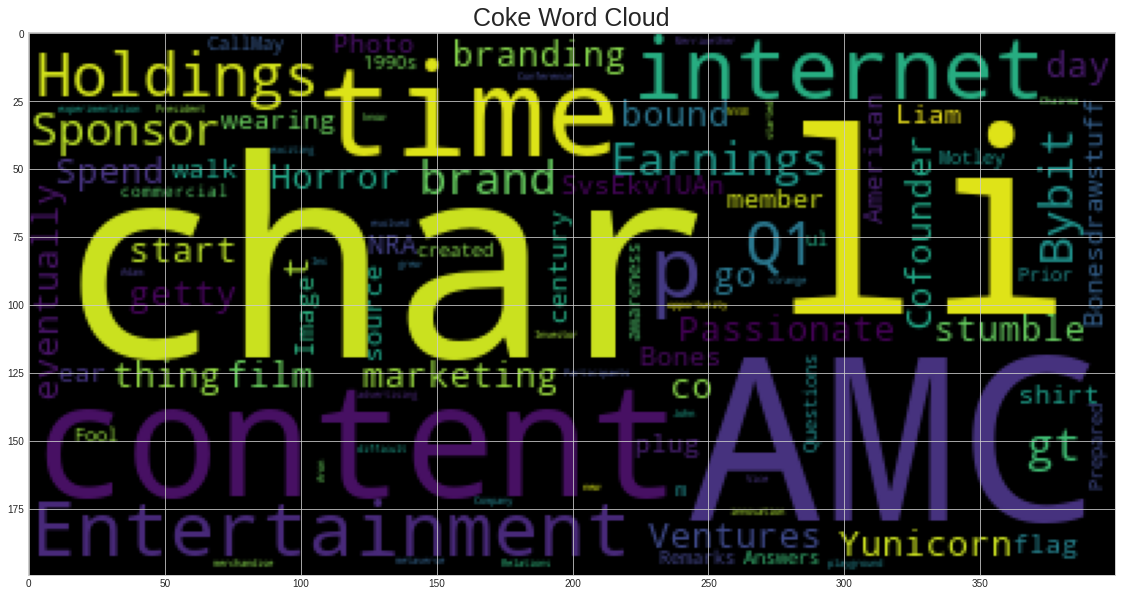

In [49]:
# Generate the wordcloud
word_cloud = WordCloud().generate(' '.join(coke_tokens))
plt.imshow(word_cloud)
plt.title("Coke Word Cloud", fontdict={'fontsize':25})